In [22]:
# import Parameters: @with_kw, @unpack
using DifferentialEquations
using Tullio, Combinatorics, LinearAlgebra
# using Zygote
using SymEngine
# using Symbolics
# using OMEinsum
using TensorOperations
using NLsolve
using Plots
using PlotlyJS
using SimpleNonlinearSolve
# using ModelingToolkit

In [116]:
function get_norm(T, g)
    """
    T should have configuration either 'u' or 'uu'
    """
    if ndims(T) == 2
         @tensor begin 
            D[] := g[u, a] * g[v, b] * T[a, b] * T[u,v]
         end
        return D[1]
        
    else
        @tensor begin 
            D[] := g[a, b] * T[a] * T[b] 
        end 
        return D[1]
    end
end

get_norm (generic function with 1 method)

In [3]:
"""
    l = levi_civita_symbol(NF)
Determine the Levi-civita psuedo tensor
"""
function levi_civita_symbol()

    # Levi civita tensor
    levi = zeros(Integer, 4, 4, 4, 4)
    for i in 1:4
        for j in 1:4
            for k in 1:4
                for l in 1:4
                    permutation_vector = [i, j, k, l]
                    levi[i, j, k, l] = levicivita(permutation_vector) #This is [i,j,k,l] from e.g. https://mathworld.wolfram.com/PermutationTensor.html
                end
            end
        end
    end

    return levi
end

"""
    ϵ = levi_civita_tensor(metric)
Calcualte the Levi-civita tensor in an arbitrary basis.
"""
function levi_civita_tensor(metric)
    ϵ = levi_civita_symbol()
    det_g = det(metric)
    return ϵ / sqrt(abs(det_g))

end

levi_civita_tensor

In [4]:
function covariant_metric(r,theta,a,M=1.0)

    """
    Define the metric tensor function.

    Parameters:
        a (float): Parameter 'a' in the metric.
        r (float): Parameter 'r' in the metric.
        theta (float): Parameter 'theta' in the metric.

    Returns:
        ndarray: The metric tensor at the given values of a, r, and theta.
        Configuration: ll
    """
    #! Correction Added Mass term in the symbols 
    g = zeros(Float64,(4, 4))

    Delta = a^2 - 2 * M * r + r^2
    Sigma = r^2 + a^2 * cos(theta) ^ 2

    g[1,1]=-(1.0-2.0*M*r/Sigma)
    g[2,2]=Sigma/Delta
    g[3,3]= Sigma
    g[4,4]=sin(theta)^2*((r^2+a^2)^2-Delta*a^2*sin(theta)^2)/Sigma
    g[1,4]=-2.0*a*M*r*sin(theta)^2/Sigma
    g[4,1]=g[1,4]

    return g

end



"""
    g=contravariant_metric(coords,a)
Construct the NxN matrix of the contravariant metric.
Metric components are defined via indvidual functions to allow for auto diff in unit tests
"""
function contravariant_metric(r,theta,a,M=1.0)
    """
    Define the metric tensor function.

    Parameters:
        a (float): Parameter 'a' in the metric.
        r (float): Parameter 'r' in the metric.
        theta (float): Parameter 'theta' in the metric.

    Returns:
        ndarray: The metric tensor at the given values of a, r, and theta.
        Configuration: uu
    """
    Delta = a^2 - 2 * M * r + r^2
    Sigma =  r^2 + a^2 * cos(theta) ^ 2

    denom= Delta*sin(theta)^2

    g = zeros(Float64,(4, 4))
    g[1,1]=-(sin(theta)^2 * ((r^2+a^2)^2- Delta*a^2 * sin(theta)^2)/Sigma)/denom

    g[2,2]=Delta/Sigma

    g[3,3]=1.0/Sigma

    # g[3, 3] = -(-(1.0 - 2.0 * r / Sigma)) / denom
    #! Corrected the g[3,3] term below
    g[4,4]= (Delta-a^2*sin(theta)^2)/(denom*Sigma)

    g[1,4]=(-2.0*a*M*r*sin(theta)^2/Sigma)/denom

    g[4,1]=g[1,4]

    return g

end


contravariant_metric

In [5]:
"""
    cs = christoffel(coords,a)
The christoffel symbols of the Kerr metric. See e.g. https://arxiv.org/pdf/0904.4184.pdf
    From Reference Paper, Appendix
    Config: ull
"""
function christoffel(r, theta, a, M=1.0, cpx=0)

    #See Catalogue of spacetimes: https://arxiv.org/pdf/0904.4184.pdf

    if cpx == 1
        cs = zeros(ComplexF64, (4, 4, 4))
    else
        cs = zeros(Float64, (4, 4, 4))
    end

    # Definitions
    Delta = a^2 - 2 * M * r + r^2
    Sigma = r^2 + a^2 * cos(theta) ^ 2


    #t
    cs[1, 1, 2] = M*(r^2 + a^2) * (r^2 - a^2 * cos(theta)^2) / (Sigma ^ 2 * Delta)
    cs[1, 1, 3] = -2*M*a^2*r*sin(theta)*cos(theta)/Sigma^2
    cs[1, 2, 4] = (
        -M
        * a
        * (2 * r^2 * (r^2 + a^2) + Sigma * (r^2 - a^2))
        * sin(theta) ^ 2
        / (Delta * Sigma^2)
    )

    cs[1, 3, 4] = M * a^3 * r * sin(theta) ^ 2 * sin(2 * theta) / Sigma^2

    #r
    cs[2, 1, 1] = M * Delta * (2 * r^2 - Sigma) / Sigma^3
    cs[2, 1, 4] = -cs[2, 1, 1] * a * sin(theta) ^ 2
    cs[2, 2, 2] = r / Sigma + (M - r) / Delta
    cs[2, 2, 3] = -(a^2) * sin(2 * theta) / (2 * Sigma)
    cs[2, 3, 3] = -r * Delta / Sigma
    cs[2, 4, 4] =  (
        -Delta
        * (r * Sigma^2 - M * a^2 * (2 * r^2 - Sigma) * sin(theta) ^ 2)
        * sin(theta) ^ 2
        / Sigma^3
    )


    #theta
    cs[3, 1, 1] = -M * a * r * sin(2 * theta) / Sigma^3 * a
    cs[3, 1, 4] = 2.0 *M* r * a * (r^2 + a^2) * sin(theta) * cos(theta) / Sigma^3
    cs[3, 2, 2] = -cs[2, 2, 3]  / Delta
    cs[3, 2, 3] = -cs[2, 3, 3] / Delta
    cs[3, 3, 3] = cs[2, 2, 3]
    cs[3, 4, 4] = (
        -(Delta * Sigma^2 + 2 * M * r * (r^2 + a^2) ^ 2)
        * sin(2 * theta)
        / (2 * Sigma^3)
    )


    #Φ
    cs[4, 1, 2] =  M * (2 * r^2 - Sigma) / (Delta * Sigma^2) * a
    cs[4, 1, 3] = -2 * M * a * r * (cos(theta)/sin(theta) )/ ( Sigma^2)
    cs[4, 2, 4] = (
        r * Sigma * (Sigma - 2 * M * r)
        - M * a^2 * (2 * r^2 - Sigma) * sin(theta) ^ 2
    ) / (Delta * Sigma^2)

    cs[4, 3, 4] = (cos(theta)/sin(theta))*(Sigma^2+2*M*a^2*r*sin(theta)^2)/Sigma^2


    #By symmetry. https://mathworld.wolfram.com/ChristoffelSymboloftheSecondKind.html
    cs[1, 2, 1] = cs[1, 1, 2]
    cs[1, 3, 1] = cs[1, 1, 3]
    cs[1, 4, 2] = cs[1, 2, 4]
    cs[1, 4, 3] = cs[1, 3, 4]


    cs[2, 4, 1] = cs[2, 1, 4]
    cs[2, 3, 2] = cs[2, 2, 3]

    cs[3, 4, 1] = cs[3, 1, 4]
    cs[3, 3, 2] = cs[3, 2, 3]

    cs[4, 2, 1] = cs[4, 1, 2]
    cs[4, 3, 1] = cs[4, 1, 3]
    cs[4, 4, 2] = cs[4, 2, 4]
    cs[4, 4, 3] = cs[4, 3, 4]

    # return symmetrize(arr=cs)+zeros(4, 4, 4)
    return cs + zeros(4, 4, 4)
    
end


christoffel

In [6]:
"""
    R = riemann(coords,a) 
Riemann tensor components of the Kerr metric. First index is the contravariant, others are covariant   
"""
function riemann(r, theta, a, M=1.0, config="ulll", cpx=0)

    if cpx==1
        rijkl = zeros(ComplexF64,(4, 4, 4, 4))
    else
        rijkl = zeros(Float64,(4, 4, 4, 4))
    end

    # Definitions
    Delta = a^2 - 2.0 * M * r + r^2
    Sigma = r^2 + a^2 * cos(theta) ^ 2


    rijkl[1,1,1,4] = (
        2.0 * M^2
        * sin(theta) ^ 2
        * a
        * r^2
        * (r^2 - 3.0 * a^2 * cos(theta) ^ 2)
        / Sigma^4
    )

    rijkl[1,1,2,3] = (
        -2.0 * M^2
        * (3.0 * r^2 - a^2 * cos(theta) ^ 2)
        * r
        * cos(theta)
        * a^2
        * sin(theta)
        / (Sigma^3 * Delta)
    )

    rijkl[1,2,1,2] = (
        M* r
        * (2.0 * (r^2 + a^2) + a^2 * sin(theta) ^ 2)
        * (r^2 - 3.0 * a^2 * cos(theta) ^ 2)
        / (Sigma^3 * Delta)
    )

    rijkl[1,2,1,3] = (
        -M* (3.0 * r^2 - a^2 * cos(theta) ^ 2)
        * (3.0 * (r^2 + a^2) - 2 *M * r)
        * a^2
        * sin(theta)
        * cos(theta)
        / (Sigma^3 * Delta)
    )

    rijkl[1,2,2,4] = (
        3.0 * M
        * sin(theta) ^ 2
        * a
        * r
        * (r^2 + a^2)
        * (r^2 - 3.0 * a^2 * cos(theta) ^ 2)
        / (Sigma^3 * Delta)
    )

    rijkl[1,2,3,4] = (
        -M * cos(theta)
        * sin(theta)
        * a
        * (3.0 * r^2 - a^2 * cos(theta) ^ 2)
        * (2.0 * (r^2 + a^2) ^ 2 + a^2 * sin(theta) ^ 2 * Delta)
        / (Sigma^3 * Delta)
    )

    
    #Antisymmetric under exchange of last two indices. 
    rijkl[1,1,4,1] = -rijkl[1,1,1,4]
    rijkl[1,1,3,2] = -rijkl[1,1,2,3]
    rijkl[1,2,2,1] = -rijkl[1,2,1,2]
    rijkl[1,2,3,1] = -rijkl[1,2,1,3] 
    rijkl[1,2,4,2] = -rijkl[1,2,2,4]  
    rijkl[1,2,4,3] = -rijkl[1,2,3,4]  


    #-----------------------------------------------------------------------#    
    

    rijkl[1,3,1,2] = (
        -M* (3.0 * r^2 - a^2 * cos(theta) ^ 2)
        * (3.0 * (r^2 + a^2) - 4 *M* r)
        * a^2
        * sin(theta)
        * cos(theta)
        / (Sigma^3 * Delta)
    )

    rijkl[1,3,1,3] = (
        -M * r
        * (r^2 - 3.0 * a^2 * cos(theta) ^ 2)
        * (r^2 + a^2 + 2 * a^2 * sin(theta) ^ 2)
        / Sigma^3
    )

    rijkl[1,3,2,4] = (
        -M * (3.0 * r^2 - a^2 * cos(theta) ^ 2)
        * ((a^2 + r^2) ^ 2 + 2.0 * a^2 * sin(theta) ^ 2 * Delta)
        * a
        * sin(theta)
        * cos(theta)
        / (Sigma^3 * Delta)
    )

    rijkl[1,3,3,4] = (
        -3.0 * M
        * sin(theta) ^ 2
        * r
        * a
        * (a^2 + r^2)
        * (r^2 - 3.0 * a^2 * cos(theta) ^ 2)
        / Sigma^3
    )

    rijkl[1,4,1,4] = (
        -sin(theta) ^ 2 * M
        * r
        * (r^2 + 3 * a^2 * sin(theta) ^ 2 - 3 * a^2)
        * ((a^2 + r^2) ^ 2 - a^2 * sin(theta) ^ 2 * Delta)
        / Sigma^4
    )

    rijkl[1,4,2,3] = (
        (3.0 * r^2 - a^2 * cos(theta) ^ 2) * M
        * ((a^2 + r^2) ^ 2 - a^2 * sin(theta) ^ 2 * Delta)
        * a
        * sin(theta)
        * cos(theta)
        / (Sigma^3 * Delta)
    )
    
    #Symmetries
    rijkl[1,3,2,1] = -rijkl[1,3,1,2]
    rijkl[1,3,3,1] = -rijkl[1,3,1,3]
    rijkl[1,3,4,2] = -rijkl[1,3,2,4]
    rijkl[1,3,4,3] = -rijkl[1,3,3,4] 
    rijkl[1,4,4,1] = -rijkl[1,4,1,4]  
    rijkl[1,4,3,2] = -rijkl[1,4,2,3]  

    
    #-----------------------------------------------------------------------# 
    
    
    rijkl[2,1,1,2] = (
        r * M
        * (r^2 - 3.0 * a^2 * cos(theta) ^ 2)
        * (a^2 * sin(theta) ^ 2 + 2.0 * Delta)
        / Sigma^4
    )

    rijkl[2,1,1,3] = (
        -3.0 * M
        * Delta
        * a^2
        * (3.0 * r^2 - a^2 * cos(theta) ^ 2)
        * sin(theta)
        * cos(theta)
        / Sigma^4
    )

    rijkl[2,1,2,4] = (
        r * M
        * a
        * (3.0 * (r^2 + a^2) - 4.0 * M * r)
        * (r^2 - 3.0 * a^2 * cos(theta) ^ 2)
        * sin(theta) ^ 2
        / Sigma^4
    )

    rijkl[2,1,3,4] = (
        -a * M
        * (2.0 * (r^2 + a^2) + a^2 * sin(theta) ^ 2)
        * (3.0 * r^2 - a^2 * cos(theta) ^ 2)
        * Delta
        * cos(theta)
        * sin(theta)
        / Sigma^4
    )

    rijkl[2,3,1,4] = (
        -cos(theta) * M
        * sin(theta)
        * a
        * (3.0 * r^2 - a^2 * cos(theta) ^ 2)
        * Delta
        / Sigma^3
    )

    rijkl[2,3,2,3] = -M* r * (r^2 - 3.0 * a^2 * cos(theta) ^ 2) / Sigma^2

    rijkl[2,4,1,2] = (
        -sin(theta) ^ 2 * M
        * r
        * a
        * (r^2 - 3.0 * a^2 * cos(theta) ^ 2)
        * (3.0 * (r^2 + a^2) - 4.0 * M * r)
        / Sigma^4
    )

    rijkl[2,4,1,3] = (
        a * M
        * (3.0 * r^2 - a^2 * cos(theta) ^ 2)
        * (r^2 + a^2 + 2.0 * a^2 * sin(theta) ^ 2)
        * Delta
        * cos(theta)
        * sin(theta)
        / Sigma^4
    )

    rijkl[2,4,2,4] = (
        -sin(theta) ^ 2 * M
        * r
        * (r^2 - 3.0 * a^2 * cos(theta) ^ 2)
        * ((r^2 + a^2) ^ 2 + 2.0 * a^2 * Delta * sin(theta) ^ 2)
        / Sigma^4
    )

    rijkl[2,4,3,4] = (
        3.0 * M
        * a^2
        * (r^2 + a^2)
        * (3.0 * r^2 - a^2 * cos(theta) ^ 2)
        * Delta
        * cos(theta)
        * sin(theta) ^ 3
        / Sigma^4
    )

    
    #Symmetries
    rijkl[2,1,2,1] = -rijkl[2,1,1,2]  
    rijkl[2,1,3,1] = -rijkl[2,1,1,3]  
    rijkl[2,1,4,2] = -rijkl[2,1,2,4] 
    rijkl[2,1,4,3] = -rijkl[2,1,3,4] 
    rijkl[2,3,4,1] = -rijkl[2,3,1,4]  
    rijkl[2,3,3,2] = -rijkl[2,3,2,3]  
    rijkl[2,4,2,1] = -rijkl[2,4,1,2]  
    rijkl[2,4,3,1] = -rijkl[2,4,1,3]  
    rijkl[2,4,4,2] = -rijkl[2,4,2,4]  
    rijkl[2,4,4,3] = -rijkl[2,4,3,4]   
    
    #-----------------------------------------------------------------------#
    
    
    rijkl[3,1,1,2] = (
        -3.0 * M
        * a^2
        * (3.0 * r^2 - a^2 * cos(theta) ^ 2)
        * sin(theta)
        * cos(theta)
        / Sigma^4
    )

    rijkl[3,1,1,3] = (
        -M * r
        * (r^2 - 3.0 * a^2 * cos(theta) ^ 2)
        * (2.0 * a^2 * sin(theta) ^ 2 + Delta)
        / Sigma^4
    )

    rijkl[3,1,2,4] = (
        -a * M
        * (3.0 * r^2 - a^2 * cos(theta) ^ 2)
        * (r^2 + a^2 + 2.0 * a^2 * sin(theta) ^ 2)
        * cos(theta)
        * sin(theta)
        / Sigma^4
    )

    rijkl[3,1,3,4] = (
        -M * r
        * a
        * (r^2 - 3.0 * a^2 * cos(theta) ^ 2)
        * (3.0 * (r^2 + a^2) - 2.0 * M * r)
        * sin(theta) ^ 2
        / Sigma^4
    )

    rijkl[3,2,1,4] = (
        M * a * (3.0 * r^2 - a^2 * cos(theta) ^ 2) * cos(theta) * sin(theta) / Sigma^3
    )

    rijkl[3,2,2,3] = M * r * (r^2 - 3.0 * a^2 * cos(theta) ^ 2) / (Delta * Sigma^2)

    rijkl[3,4,1,2] = (
        M * a
        * (2.0 * (r^2 + a^2) + a^2 * sin(theta) ^ 2)
        * (3.0 * r^2 - a^2 * cos(theta) ^ 2)
        * cos(theta)
        * sin(theta)
        / Sigma^4
    )

    rijkl[3,4,1,3] = (
        M * r
        * a
        * (r^2 - 3.0 * a^2 * cos(theta) ^ 2)
        * (3.0 * (r^2 + a^2) - 2.0 * M * r)
        * sin(theta) ^ 2
        / Sigma^4
    )

    rijkl[3,4,2,4] = (
        3.0 * M
        * a^2
        * (r^2 + a^2)
        * (3.0 * r^2 - a^2 * cos(theta) ^ 2)
        * cos(theta)
        * sin(theta) ^ 3
        / Sigma^4
    )

    rijkl[3,4,3,4] = (
        M * r
        * (r^2 - 3.0 * a^2 * cos(theta) ^ 2)
        * (2.0 * (r^2 + a^2) ^ 2 + a^2 * Delta * sin(theta) ^ 2)
        * sin(theta) ^ 2
        / Sigma^4
    )

    
    #Symmetries
    rijkl[3,1,2,1] = -rijkl[3,1,1,2]  
    rijkl[3,1,3,1] = -rijkl[3,1,1,3]  
    rijkl[3,1,4,2] = -rijkl[3,1,2,4] 
    rijkl[3,1,4,3] = -rijkl[3,1,3,4] 
    rijkl[3,2,4,1] = -rijkl[3,2,1,4]  
    rijkl[3,2,3,2] = -rijkl[3,2,2,3]  
    rijkl[3,4,2,1] = -rijkl[3,4,1,2]  
    rijkl[3,4,3,1] = -rijkl[3,4,1,3]  
    rijkl[3,4,4,2] = -rijkl[3,4,2,4]  
    rijkl[3,4,4,3] = -rijkl[3,4,3,4]   
    
    #-----------------------------------------------------------------------#
        
    rijkl[4,1,2,3] = (
        -M * (3.0 * r^2 - a^2 * cos(theta) ^ 2) * (a^2 * sin(theta) ^ 2 - Delta)
        * a * (cos(theta) / sin(theta))
        / (Delta * Sigma^3)
    )

    rijkl[4,2,1,2] = (
        3.0 * M * r * a * (r^2 - 3.0 * a^2 * cos(theta) ^ 2)
        / (Delta * Sigma^3)
    )

    rijkl[4,2,1,3] = (
        -M * a * (3.0 * r^2 - a^2 * cos(theta) ^ 2) * (2.0 * a^2 * sin(theta) ^ 2 + Delta)
        * (cos(theta) / sin(theta))
        / (Delta * Sigma^3)
    )

    rijkl[4,2,2,4] = (
        M * r * (r^2 - 3.0 * a^2 * cos(theta) ^ 2) * (r^2 + a^2 + 2.0 * a^2 * sin(theta) ^ 2)
        / (Delta * Sigma^3)
    )

    rijkl[4,2,3,4] = (
        -M * (3.0 * r^2 - a^2 * cos(theta) ^ 2) * (3.0 * (r^2 + a^2) - 2.0 * M * r) * a^2 * sin(theta) * cos(theta)
        / (Delta * Sigma^3)
    )

    rijkl[4,3,1,2] = (
        -M * (3.0 * r^2 - a^2 * cos(theta) ^ 2) * (a^2 * sin(theta) ^ 2 + 2.0 * Delta)
        * a * (cos(theta) / sin(theta))
        / (Delta * Sigma^3)
    )

    rijkl[4,3,1,3] = (
        -M * 3.0 * r * a * (r^2 - 3.0 * a^2 * cos(theta) ^ 2)
        / Sigma^3
    )

    rijkl[4,3,2,4] = (
        -M * a^2 * (3 * r^2 - a^2 * cos(theta) ^ 2) * (3.0 * (r^2 + a^2) - 4.0 * M * r) * sin(theta) * cos(theta)
        / (Delta * Sigma^3)
    )

    rijkl[4,3,3,4] = (
        -M * r * (2.0 * (r^2 + a^2) + a^2 * sin(theta) ^ 2) * (r^2 - 3.0 * a^2 * cos(theta) ^ 2)
        / Sigma^3
    )

    rijkl[4,4,1,4] = (
        -2.0 * M^2 * a * r^2 * (r^2 - 3.0 * a^2 * cos(theta) ^ 2) * sin(theta) ^ 2
        / Sigma^4
    )

    rijkl[4,4,2,3] = (
        2.0 * M^2 * r * a^2 * (3.0 * r^2 - a^2 * cos(theta) ^ 2) * cos(theta) * sin(theta)
        / (Delta * Sigma^3)
    )

    
    #Symmetries
    rijkl[4,1,3,2] = -rijkl[4,1,2,3]  
    rijkl[4,2,2,1] = -rijkl[4,2,1,2]  
    rijkl[4,2,3,1] = -rijkl[4,2,1,3] 
    rijkl[4,2,4,2] = -rijkl[4,2,2,4] 
    rijkl[4,2,4,3] = -rijkl[4,2,3,4]  
    rijkl[4,3,2,1] = -rijkl[4,3,1,2]  
    rijkl[4,3,3,1] = -rijkl[4,3,1,3]  
    rijkl[4,3,4,2] = -rijkl[4,3,2,4]  
    rijkl[4,3,4,3] = -rijkl[4,3,3,4]  
    rijkl[4,4,4,1] = -rijkl[4,4,1,4]   
    rijkl[4,4,3,2] = -rijkl[4,4,2,3]   



    #Additional complicated terms - can these be algebrically simplified?
    part1= a^2 + 2*r*(-2*M +r) +a^2*cos(2*theta)
    part2= 3*a^2 -2*r^2 +3*a^2*cos(2*theta)
    part3= (a^2+ 2* r^2+ a^2*cos(2*theta))^4

    rijkl[4,1,1,4]  =4.0*M*r*part1*part2/part3
    rijkl[4,1,4,1] = -rijkl[4,1,1,4]
    
    
    # return rijkl
    if config=="ulll"
        return rijkl+ zeros(Float64,(4,4,4,4))

    elseif config=="llll"
        gk=covariant_metric(r,theta,a,M)
        @tensor begin 
            rllll[i, k, l, m] := gk[i, j] * rijkl[j, k, l, m]
 
        end 
        return rllll+zeros(Float64,(4,4,4,4))
        # return einsum("ij,jklm->iklm", gk, rijkl) + zeros((4, 4, 4, 4))

    else
        return "Invalid String"
    end

end


riemann

In [7]:
function metric_D(r,theta,a,M=1.0)
    dgkp=zeros(Float64,(4,4))
    dgkt= zeros(Float64,(4,4))
    
    denom = (r^2+a^2*cos(theta)^2)^2

    dgkt[2, 1] = M*(a^2-2*r^2+a^2*cos(2*theta))/denom

    dgkt[2, 4] = -(2*a*M*(-r^2+a^2*cos(theta)^2)*sin(theta)^2)/denom
    dgkt[3, 1] = 2*a^2*M*r*sin(2*theta)/denom
    dgkt[3, 4] = -2*a*M*r*(r^2+a^2)*sin(2*theta)/denom

    dgkp[2, 1] = -2*a*M*(-r^2+a^2*cos(theta)^2)*sin(theta)^2/denom
    dgkp[2, 4] = 2*sin(theta)^2*(cos(theta)^2*(2*a^2*r*(a^2+r^2)+a^4*(M-r)*sin(theta)^2)+r*(-a^4+r^4+a^2*(a^2-M*r)*sin(theta)^2))/denom
    dgkp[3, 1] = -2*a*M*r*(a^2+r^2)*sin(2*theta)/denom
    dgkp[3, 4] = (3*a^6+10*a^4*M*r+11*a^4*r^2+16*a^2*M*r^3+16*a^2*r^4+8*r^6+4*a^2*(a^2+2*r^2)*(a^2+r*(-2*M+r))*cos(2*theta)+a^4*(a^2-2*M*r+r^2)*cos(4*theta))*sin(2*theta)/(8*denom)

    return transpose(dgkt) .+ zeros(Float64,(4, 4)), transpose(dgkp) .+ zeros(Float64,(4, 4))
    
end

metric_D (generic function with 2 methods)

In [44]:
function energy(gk, pvector, Stensor, dgkt)
    @tensor begin 
        pvecl[i] := gk[i, j] * pvector[j]
 end 
    @tensor begin 
        term2[] := dgkt[u, v] * Stensor[u, v] / 2.0
    end 

    return -pvecl[1]+ term2[1]

end

energy (generic function with 1 method)

In [55]:
function angular_momentum(gk, pvector, Stensor, dgkp)
    @tensor begin 
        pvecl[i] := gk[i, j] * pvector[j]
 
    end
    @tensor begin 
        term2[] := dgkp[u, v] * Stensor[u, v] / 2.0
 
    end 

    return pvecl[4]- term2[1]
    
end

angular_momentum (generic function with 1 method)

In [115]:
function spintensor(levi, pvector, svector, gk, m)
    @tensor begin 
        p_vectorl[i] := gk[i, j] * pvector[j]
    end 

    @tensor begin 
        s_vectorl[i] := gk[i, j] * svector[j]
    end 
    
    @tensor begin 
        ret[u, v] := levi[u, v, a, b] * p_vectorl[a] * s_vectorl[b] / m
    end 
    return ret
    
end

spintensor (generic function with 1 method)

In [11]:
function to_cartesian(rsol)
    r, t, p = rsol[2], rsol[3], rsol[4]
    vr, vt, vp = rsol[5], rsol[6], rsol[7]

    x = r .* sin(t) .* cos(p)
    y = r .* sin(t) .* sin(p)
    z = r .* cos(t)

    vx = vr .* sin(vt) .* cos(vp)
    vy = vr .* sin(vt) .* sin(vp)
    vz = vr .* cos(vt)

    return hcat(x, y, z), hcat(vx, vy, vz)
end


to_cartesian (generic function with 1 method)

In [12]:
function calculate_four_momentum(pvector, uvector, svector, cs, Riemann, levi_mixed, m0)

    @tensor begin 
      correction[α] := (Riemann[α, β, ρ, σ] * levi_mixed[ρ, σ, μ, ν] * uvector[β] * svector[μ] * pvector[ν]) / (2.0 * m0)
   end 

    @tensor begin 
      dp[α] := cs[α, μ, ν] * pvector[μ] * uvector[ν]
 
      end  

    return correction - dp
end

calculate_four_momentum (generic function with 1 method)

In [13]:
function calculate_four_spin(pvector, uvector, svector, cs, Riemann_cov, levi_mixed, m)

    @tensor begin 
      correction[α] := pvector[α] * (Riemann_cov[γ, β, ρ, σ] * levi_mixed[ρ, σ, μ, ν] * svector[γ] * uvector[β] * svector[μ] * pvector[ν]) / (2.0 * m^3)
   end 

    @tensor begin 
      ds[α] := cs[α, μ, ν] * svector[μ] * uvector[ν]
   end 

    return correction - ds
end

calculate_four_spin (generic function with 1 method)

In [80]:
function calculate_four_velocity(pvector, Stensor, Riemann_cov, m0)

    @tensor begin 
        scalar_divisor[] := Riemann_cov[μ, ν, ρ, σ] * Stensor[μ, ν] * Stensor[ρ, σ] / 4.0
    end 

    @tensor begin 
        correction[α] := (Stensor[α, β] * Riemann_cov[β, γ, μ, ν] * pvector[γ] * Stensor[μ, ν]) 
    end 

    correction = correction / (2.0 * (m0^2 + scalar_divisor[1]))

    dx= (pvector.+correction)./m0

    # @tulli`o Vsq := g[μ, ν] * dx[μ] * dx[ν]

    # PV = -sqrt(-1 / Vsq)
    PV=1.0
    dx = dx * PV

    return dx
end

calculate_four_velocity (generic function with 1 method)

In [15]:
function MPD!(du, u, p, τ)

    #Extract the coordinates/constants 
    t, r, theta, ϕ, pᵗ, pʳ, pᶿ, pᵠ, sᵗ, sʳ, sᶿ, sᵠ = u # coordinate variables
    a, m, M = p                            # constants
    #Define vectors from the coordinate variables. 
    # xvector = [t, r, theta, ϕ]
    pvector = u[5:8]
    svector = u[9:end]


    # # #Define some useful quantities for this timestep 
    gk = covariant_metric(r, theta, a ,M)        # the metric 
    cs = christoffel(r,theta, a, M)            # the Christoffel symbols
    Riemann = riemann(r, theta, a, M, "ulll")          #the mixed contra/covar Riemann term R^{a}_{bcd}
    levi = levi_civita_tensor(gk)  #This is the fully contravariant Levi Civita tensor 

    @tensor begin 
        levi_mixed[ρ, σ, μ, ν] := levi[ρ, σ, x, y] * gk[x, μ] * gk[y, ν]
    end 

    @tensor begin 
        Riemann_cov[μ, ν, ρ, σ] := gk[μ, λ] * Riemann[λ, ν, ρ, σ] #This is the fully covariant form R_{abcd}
    end 

    stensor = spintensor(levi, pvector, svector,gk, m) #the fully contravariant spin tensor s^{ab}

    # Get the derivative objects
    # 4-velocity
    uvector = calculate_four_velocity(pvector, stensor, Riemann_cov, m)

    # 4-momentum
    dp = calculate_four_momentum(pvector, uvector, svector, cs, Riemann, levi_mixed, m)

    # 4-spin
    ds = calculate_four_spin(pvector, uvector, svector, cs, Riemann_cov, levi_mixed, m)

    du[1:4] = uvector
    du[5:8] = dp
    du[9:end] = ds

    nothing #function returns nothing
    # return du


end

MPD! (generic function with 1 method)

In [16]:
M = 20.0
m = 12e0

S = 1.0 * m * M
E = 0.9328 * m
Jz = 2.8 * m * M

r0 = 6.0 * M
theta0 = pi / 3.0 # In the units of pi
phi0 = 0.0
a0 = 0.8*M

S1 = 0.0
S3 = 0.0

P2 = 0.0

0.0

In [17]:
gk = covariant_metric(r0,theta0,a0,M)

4×4 Matrix{Float64}:
 -0.668142  0.0          0.0     -3.9823
  0.0       1.46753      0.0      0.0
  0.0       0.0      14464.0      0.0
 -3.9823    0.0          0.0  11039.8

In [18]:
gkinv = contravariant_metric(r0, theta0, a0, M)

4×4 Matrix{Float64}:
 -1.49348      0.0       0.0         -0.000538731
  0.0          0.681416  0.0          0.0
  0.0          0.0       6.91372e-5   0.0
 -0.000538731  0.0       0.0          9.03871e-5

In [19]:
cs= christoffel(r0,theta0,a0,M)

4×4×4 Array{Float64, 3}:
[:, :, 1] =
  0.0          0.00203796  -0.00254334    0.0
  0.000933885  0.0          0.0          -0.0112066
 -1.7584e-7    0.0          0.0           0.000161069
  0.0          2.22485e-6  -0.000211945   0.0

[:, :, 2] =
 0.00203796   0.0          0.0         -0.0729413
 0.0         -0.00184964  -0.00766394   0.0
 0.0          7.77591e-7   0.00829646   0.0
 2.22485e-6   0.0          0.0          0.00810814

[:, :, 3] =
 -0.00254334    0.0           0.0         0.0305201
  0.0          -0.00766394  -81.7699      0.0
  0.0           0.00829646   -0.00766394  0.0
 -0.000211945   0.0           0.0         0.579894

[:, :, 4] =
  0.0          -0.0729413   0.0305201    0.0
 -0.0112066     0.0         0.0        -61.193
  0.000161069   0.0         0.0         -0.442601
  0.0           0.00810814  0.579894     0.0

In [20]:
rllll= riemann(r0,theta0,a0,M,"llll");
rulll = riemann(r0, theta0, a0, M, "ulll");

In [21]:
rllll;

In [23]:
@vars p0 p1 p3

(p0, p1, p3)

In [24]:
p_coordu = [p0, p1, P2, p3]

4-element Vector{Basic}:
  p0
  p1
 0.0
  p3

In [25]:
s_coordu = [0.0, S1, S/sqrt(gk[3,3]), S3]

4-element Vector{Float64}:
 0.0
 0.0
 1.9955703157132179
 0.0

In [26]:
get_norm(s_coordu,gk)

0-dimensional Array{Float64, 0}:
57600.0

In [27]:
@tensor begin 
    cps[] := gk[i, j] * p_coordu[j] * s_coordu[i]
 end 

0-dimensional Array{Basic, 0}:
0

In [28]:
Delta = a0^2 - 2 * M * r0 + r0^2
Sigma = r0^2 + a0^2 * cos(theta0) ^ 2

14464.0

In [29]:
levi= levi_civita_tensor(gk);

In [30]:
Suv= spintensor(levi,p_coordu,s_coordu,gk,m)

4×4 Matrix{Basic}:
                                                              0  …                                              0.281801224378605*p1
 0.192023843160642*(-3.98230088495575*p0 + 11039.7876106195*p3)     -0.192023843160642*(-0.668141592920354*p0 - 3.98230088495575*p3)
                                                              0                                                                    0
                                          -0.281801224378605*p1                                                                    0

In [31]:
# Symbolics.value.(expand(Suv[3,4]))

In [32]:
dgkt, dgkp = metric_D(r0, theta0, a0, M);

In [33]:
dgkt

4×4 Matrix{Float64}:
 0.0  -0.00274101   0.00508669  0.0
 0.0   0.0          0.0         0.0
 0.0   0.0          0.0         0.0
 0.0   0.0328922   -4.65941     0.0

In [46]:
eq210a = energy(gk, p_coordu, Suv, dgkt)- E;

In [54]:
SymEngine.expand(eq210a)

-11.1936 + 0.664983553366455*p0 + 6.87506511632713*p3

In [47]:
# Symbolics.value.(expand(eq210a))

In [56]:
eq210b = angular_momentum(gk, p_coordu, Suv, dgkp) - Jz;

In [57]:
SymEngine.expand(eq210b)

-672.0 + 7.52672312072103*p0 + 11143.3234862455*p3

In [58]:
eq533= get_norm(p_coordu,gk)[1]+m^2;

In [59]:
SymEngine.expand(eq533)

144.0 - 7.9646017699115*p0*p3 - 0.668141592920354*p0^2 + 1.46753246753247*p1^2 + 11039.7876106195*p3^2

In [60]:
# feq533 = build_function(eq533, p0, p1, p3,expression= Val{false})
# feq210a = build_function(eq210a, p0, p1, p3,expression= Val{false})
# feq210b = build_function(eq210b, p0, p1, p3,expression= Val{false});

In [64]:
feq533 = SymEngine.lambdify(eq533, [p0, p1, p3])
feq210a = lambdify(eq210a, [p0, p1, p3])
feq210b = lambdify(eq210b, [p0, p1, p3])

#36 (generic function with 1 method)

In [65]:
feq210a(m,m,m),feq210b(m,m,m),feq533(m,m,m)

(79.286984036323, 133138.20251239507, 1.58884162556028e6)

In [66]:
function solve_eq(u)
    [feq210a(u[1], u[2], u[3]),
        feq210b(u[1], u[2], u[3]),
        feq533(u[1], u[2], u[3])]

end

solve_eq (generic function with 1 method)

In [67]:
sol = nlsolve(solve_eq, [16.0, 3.0, 0.05], ftol=1e-12, iterations=1000000)

Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [16.0, 3.0, 0.05]
 * Zero: [16.323410830540514, 3.0471004810715994, 0.04927957148247169]
 * Inf-norm of residuals: 0.000000
 * Iterations: 4
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-12: true
 * Function Calls (f): 5
 * Jacobian Calls (df/dx): 5

In [68]:
sol.zero

3-element Vector{Float64}:
 16.323410830540514
  3.0471004810715994
  0.04927957148247169

In [69]:
solve_eq(sol.zero)

3-element Vector{Float64}:
 -6.938893903907228e-16
 -7.105427357601002e-14
  0.0

In [70]:
np_coordu = [sol.zero[1], sol.zero[2], 0.0, sol.zero[3]]

4-element Vector{Float64}:
 16.323410830540514
  3.0471004810715994
  0.0
  0.04927957148247169

In [72]:
@tensor begin 
    eq533[] := gk[μ, ν] * np_coordu[μ] * np_coordu[ν]
 end 

0-dimensional Array{Float64, 0}:
-144.0

In [73]:
ns_coordu = [0.0, 0.0, S/sqrt(gk[3,3]), 0.0]

4-element Vector{Float64}:
 0.0
 0.0
 1.9955703157132179
 0.0

In [74]:
@tensor begin 
    eq533[] := gk[μ, ν] * ns_coordu[μ] * ns_coordu[ν]
 end 

0-dimensional Array{Float64, 0}:
57600.0

In [75]:
levi = levi_civita_tensor(gk);

In [76]:
NSuv= spintensor(levi,np_coordu,ns_coordu,gk,m)

4×4 Matrix{Float64}:
  0.0       -91.9854   0.0  0.858677
 91.9854      0.0      0.0  2.13196
  0.0         0.0      0.0  0.0
 -0.858677   -2.13196  0.0  0.0

In [77]:
angular_momentum(gk, np_coordu, NSuv, dgkp)

671.9999999999998

In [81]:
vmu0 = calculate_four_velocity(np_coordu,NSuv,rllll,m)

4-element Vector{Float64}:
 1.362133626474989
 0.25418935257803027
 0.0
 0.004147027286618517

In [83]:
@tensor begin 
    m2[] := gk[i, x] * np_coordu[x] * np_coordu[i] / m^2
 end 

0-dimensional Array{Float64, 0}:
-1.0

In [84]:
@tensor begin 
    levi_mixed[p, s, u, v] := levi[p, s, x, y] * gk[x, u] * gk[y, v]
 end 

4×4×4×4 Array{Float64, 4}:
[:, :, 1, 1] =
 0.0   0.0          0.0          0.0
 0.0   0.0          1.01057e-20  0.0
 0.0  -1.01057e-20  0.0          0.0
 0.0   0.0          0.0          0.0

[:, :, 2, 1] =
  0.0          0.0   0.000466555  0.0
  0.0          0.0   0.0          0.0
 -0.000466555  0.0   0.0          7.82775e-5
  0.0          0.0  -7.82775e-5   0.0

[:, :, 3, 1] =
 0.0      -4.59836   0.0   0.0
 4.59836   0.0       0.0  -0.771503
 0.0       0.0       0.0   0.0
 0.0       0.771503  0.0   0.0

[:, :, 4, 1] =
 0.0   0.0       0.0       0.0
 0.0   0.0       0.590124  0.0
 0.0  -0.590124  0.0       0.0
 0.0   0.0       0.0       0.0

[:, :, 1, 2] =
 0.0          0.0  -0.000466555   0.0
 0.0          0.0   0.0           0.0
 0.000466555  0.0   0.0          -7.82775e-5
 0.0          0.0   7.82775e-5    0.0

[:, :, 2, 2] =
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0

[:, :, 3, 2] =
 0.0      0.0  0.0  -1.69456
 0.0      0.0  0.0   0.0
 0.0     

In [85]:
calculate_four_spin(np_coordu, vmu0, ns_coordu, cs, rllll, levi_mixed, m)

4-element Vector{Float64}:
  0.025023309737340235
  0.007315290618744428
 -0.004208402045700318
 -0.004167464412518848

In [86]:
calculate_four_momentum(np_coordu, vmu0, ns_coordu, cs, rulll, levi_mixed, m)

4-element Vector{Float64}:
 -0.014226912869054727
 -0.0032989556344746912
  7.765600913103404e-5
 -0.00022155845736680023

In [95]:
function get_constants(rsol, gk, a=a0, M=1.0)
    _, r, theta, _ = rsol[1:4]
    pmuu = rsol[5:8]
    smuu = rsol[9:end]

    dgkt, dgkp = metric_D(r, theta, a, M)

    levi = levi_civita_tensor(gk) #!'uuuu', tetrad
    # Sab=spin_matrix(sa=si,pb=pi,gk=gk,epsilon=epsilon)
    Suv = spintensor(levi, pmuu, smuu, gk, m)

    E = energy(gk, pmuu, Suv, dgkt)
    Jz = angular_momentum(gk, pmuu, Suv, dgkp)

    mu = get_norm(pmuu, gk)[1]
    Smag = get_norm(smuu, gk)[1]

    @tensor begin 
        ps[] := gk[i, j] * pmuu[j] * smuu[i]
    end 

    return E, Jz, mu, Smag,ps[1]
end


get_constants (generic function with 3 methods)

In [96]:
y0 = [0.0, r0, theta0, phi0, np_coordu[1], np_coordu[2], np_coordu[3], np_coordu[4], ns_coordu[1], ns_coordu[2], ns_coordu[3], ns_coordu[4]]

12-element Vector{Float64}:
   0.0
 120.0
   1.0471975511965976
   0.0
  16.323410830540514
   3.0471004810715994
   0.0
   0.04927957148247169
   0.0
   0.0
   1.9955703157132179
   0.0

In [97]:
dy=zeros(12);

In [98]:
MPD!(dy,y0,[a0,m,M],0.0)

In [99]:
dy

12-element Vector{Float64}:
  1.362133626474989
  0.25418935257803027
  0.0
  0.004147027286618517
 -0.014226912869054727
 -0.0032989556344746912
  7.765600913103404e-5
 -0.00022155845736680023
  0.025023309737340235
  0.007315290618744428
 -0.004208402045700318
 -0.004167464412518848

In [100]:
get_constants(y0, gk, a0, M)

(11.1936, 671.9999999999998, -144.0, 57600.0, 0.0)

In [101]:
t_span = (0.0, 10000.0)

(0.0, 10000.0)

In [102]:
p = [a0, m,M]

3-element Vector{Float64}:
 16.0
 12.0
 20.0

In [103]:
prob = ODEProblem(MPD!, y0, t_span, p)

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 10000.0)
u0: 12-element Vector{Float64}:
   0.0
 120.0
   1.0471975511965976
   0.0
  16.323410830540514
   3.0471004810715994
   0.0
   0.04927957148247169
   0.0
   0.0
   1.9955703157132179
   0.0

In [104]:
saveat = range(start=0.0, stop=10000, step=1)

0.0:1.0:10000.0

In [105]:
sol = solve(prob, reltol=1e-13, abstol=1e-13, maxiters=1e6)

retcode: Success
Interpolation: specialized 7th order lazy interpolation, specialized 4rd order "free" stiffness-aware interpolation
t: 1333-element Vector{Float64}:
     0.0
     0.008223201223093064
     0.026302927422381238
     0.07112045941105073
     0.16485730837584583
     0.31853794867329727
     0.5641875234957221
     0.9671214820456215
     1.646104926312081
     2.589921159999045
     ⋮
  9934.49664923931
  9943.243801391343
  9951.940396641787
  9960.561653515602
  9969.13477744321
  9977.654662942612
  9986.126100519681
  9994.547341026357
 10000.0
u: 1333-element Vector{Vector{Float64}}:
 [0.0, 120.0, 1.0471975511965976, 0.0, 16.323410830540514, 3.0471004810715994, 0.0, 0.04927957148247169, 0.0, 0.0, 1.9955703157132179, 0.0]
 [0.011201058122071658, 120.00209024080199, 1.0471975514175675, 3.4101200629541996e-5, 16.323293842905944, 3.0470733527409695, 6.385469194576425e-7, 0.0492777496100916, 0.00020575954410059408, 6.015013525636142e-5, 1.9955357097088877, -3.42687388151

In [106]:
# poi_points = filter(x -> abs(x[3] - pi / 2) < 1e-13, sol.u)

In [107]:
corbit = map(x -> to_cartesian(x), sol.u);
xcorbit = [corbit[i][1] for i in 1:length(corbit)];

In [108]:
# layout = Layout(
#     width=800,
#     height=700,
#     autosize=false,
#     scene=attr(
#         camera=attr(
#             up=attr(x=0, y=0, z=1),
#             eye=attr(x=0, y=1.0707, z=1)
#         ),
#         aspectratio=attr(x=1, y=1, z=0.7),
#         aspectmode="manual",
#     )
# )
# PlotlyJS.plot(PlotlyJS.scatter(
#         x=getindex.(xcorbit, 1),
#         y=getindex.(xcorbit, 2),
#         z=getindex.(xcorbit, 3),
#         marker=attr(size=4, color=getindex.(xcorbit, 3), colorscale="Viridis"),
#         line=attr(color="darkblue", width=2),
#         type="scatter3d",
#         mode="lines+markers"
#     ), layout)

In [109]:
rsol= sol.u;

In [110]:
rsol[end]

12-element Vector{Float64}:
 12784.096289039022
   163.00274578578075
     2.1105575507737098
    31.009094223969942
    14.672153091201109
    -2.323808115777899
     0.0008822717119736015
     0.0263222461118665
    12.281003382549587
     4.517610976241001
     1.45677354342582
     0.24371557734361718

In [111]:
E,Jz

(11.1936, 671.9999999999999)

In [112]:
rsol[end][9:end]

4-element Vector{Float64}:
 12.281003382549587
  4.517610976241001
  1.45677354342582
  0.24371557734361718

In [113]:
E,Jz,m^2,S^2

(11.1936, 671.9999999999999, 144.0, 57600.0)

In [114]:
# end = end
gki=covariant_metric(rsol[end][1],rsol[end][2],a0,M)
get_constants(rsol[end], gki, a0, M)[1] - E, get_constants(
    rsol[end], gki, a0, M)[2] - Jz, get_constants(rsol[end], gki, a0, M)[3] + m^2, get_constants(
    rsol[end], gki, a0, M)[4] - S^2

(140.07395800304772, 535603.310573325, 14119.753961526636, 3.4798387157788926e8)

In [77]:
function calculate_motconst(rsol, a0, M, E, Jz, m, S)
    motconst = Vector{Vector{Float64}}(undef, length(rsol))
    for i in 1:length(rsol)
        motconst[i] = get_constants(rsol[i], covariant_metric(rsol[i][1], rsol[i][2], a0, M), a0, M) .- [E, Jz, m^2, S^2, 0.0]
    end
    return motconst
end

calculate_motconst (generic function with 1 method)

In [107]:
motconst= calculate_motconst(rsol,a0,M,E,Jz,m,S);

In [108]:
motconst

1334-element Vector{Vector{Float64}}:
 [5.054589544435764, -247.87106592339666, -404.089342386727, -56924.203511514825, 0.0]
 [5.012297566318299, -250.39870157598983, -403.40935778095707, -56926.24250833698, -0.0031516688292181215]
 [4.91902593588739, -255.9040634306944, -401.91054102098065, -56930.7033229188, -0.00992972554037494]
 [4.713814176275214, -267.6996370362353, -398.6168285403261, -56940.344455013605, -0.024011723858781666]
 [4.297106844436318, -290.45303301004805, -391.94396448106966, -56959.20132993168, -0.049147779966429085]
 [3.5802188609993344, -326.52536014761785, -380.5066892636163, -56989.473867161825, -0.08190343159152454]
 [2.288257342976614, -384.5627270468204, -360.0031211617786, -57037.72840334123, -0.10970969144426951]
 [0.008968797209810475, -474.20400070835854, -324.0673247916891, -57106.62747000309, -0.07351660456958478]
 [-5.35910249094567, -659.3788828572672, -240.07189510398433, -57215.47797780415, 0.33265806873960113]
 [-23.77830962197733, -1244.06568289

In [109]:
length(motconst[1])

5

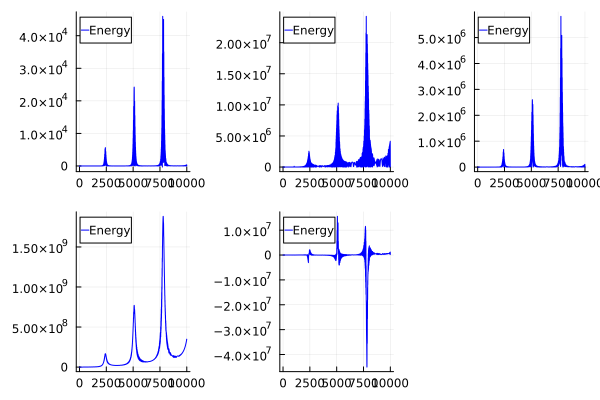

In [110]:
#Create a 3x2 grid of subplots
# plt = @layout [a b; c d; e f]

# # Plot the data in the respective subplots
# p1 = Plots.plot!(sol.t, getindex.(motconst,1), label="Energy", color=:blue, subplot=1, layout=plt)
# p2 = Plots.plot!(sol.t, getindex.(motconst,2), label="Jz", color=:green, subplot=2, layout=plt)
# p3 = Plots.plot!(sol.t, getindex.(motconst,3), label="m^2", color=:red, subplot=3, layout=plt)
# p4 = Plots.plot!(sol.t, getindex.(motconst,4), label="S^2", color=:purple, subplot=4, layout=plt)
# p5 = Plots.plot!(sol.t, getindex.(motconst,5), label=raw"$p_v S^v$", color=:orange, subplot=5, layout=plt)

plot_array = Any[] # can type this more strictly
for i in 1:length(motconst[1])
    push!(plot_array, Plots.plot(sol.t, getindex.(motconst, i), label="Energy", color=:blue)) # make a plot and add it to the plot_array
end
Plots.plot(plot_array...)
# Display the plot
# display(Plots.plot(p1, p2, p3, p4, p5, layout=plt))


In [111]:
M = 1e0
m = 1e0

S = 1.0 * m * M
E = 0.9328 * m
Jz = 2.8 * m * M

r0 = 6.0 * M
theta0 = pi / 2.0 # In the units of pi
phi0 = 0.0
a0 = 0.8 * M

0.8

In [ ]:
gk = covariant_metric(r0, theta0, a0, M)

In [ ]:
gkinv = contravariant_metric(r0, theta0, a0, M)

In [ ]:
cs = christoffel(r0, theta0, a0, M)

In [ ]:
rllll = riemann(r0, theta0, a0, M, "llll");
rulll = riemann(r0, theta0, a0, M, "ulll");

In [ ]:
levi = levi_civita_tensor(gk);

In [ ]:
dgkt, dgkp = metric_D(r0, theta0, a0, M)

In [ ]:
P1 = 1e-2 * m

In [ ]:
S1 = 1e-2 * m
S2 = 1e-1 * m

In [ ]:
@variables p0 p2 p3 s0 s3

In [ ]:
gpcoordu = [p0, P1, p2, p3]
gscoordu = [s0, S1, S2, s3]

In [ ]:
Delta = a0^2 - 2 * M * r0 + r0^2
Sigma = r0^2 + a0^2 * cos(theta0) ^ 2

In [ ]:
Suv = spintensor(levi, gpcoordu, gscoordu, gk, m)

In [ ]:
eq210a = energy(gk, gpcoordu, Suv, dgkt) - E;

In [ ]:
expand(eq210a)

In [ ]:
eq210b = angular_momentum(gk, gpcoordu, Suv, dgkp) - Jz;

In [ ]:
expand(eq210b)

In [ ]:
@tensor begin 
    eq533 := gk[μ, ν] * gpcoordu[μ] * gpcoordu[ν]
 end 
eq533 = eq533 + m^2

In [ ]:
@tensor begin 
    eq229 = gk[μ, ν] * gpcoordu[μ] * gscoordu[ν]
 end 

In [ ]:
@tensor begin 
    eq228 := gk[μ, ν] * gscoordu[μ] * gscoordu[ν]
 end 
eq228 = eq228 -S^2

In [ ]:
jac = Symbolics.jacobian([eq210a, eq210b, eq533, eq228, eq229], [p0, p2, p3, s0, s3], simplify=true, scalarize=true);

In [ ]:
# jac_bf = build_function(jac, p0, p2, p3, s0, s3, expression=Val{false});

function jac_nl_sp(u)
    return Symbolics.value.(substitute.(jac, (Dict(p0 => u[1], p2 => u[2], p3 => u[3], s0 => u[4], s3 => u[5]),)))
    
end

In [ ]:
jac_nl_sp([m,m,m,m,m])

In [ ]:
feq533 = build_function(eq533, p0, p2, p3,s0,s3, expression=Val{false})
feq210a = build_function(eq210a, p0, p2, p3,s0,s3, expression=Val{false})
feq210b = build_function(eq210b, p0, p2, p3,s0,s3, expression=Val{false})
feq228= build_function(eq228, p0, p2, p3,s0,s3, expression=Val{false})
feq229 = build_function(eq229, p0, p2, p3,s0,s3, expression=Val{false});

In [ ]:
feq210a(m, m, m,m,m), feq210b(m, m, m,m,m), feq533(m, m, m,m,m)

In [ ]:
function solve_eq(u)
    [feq210a(u[1], u[2], u[3],u[4],u[5]),
        feq210b(u[1], u[2], u[3],u[4],u[5]),
        feq533(u[1], u[2], u[3],u[4],u[5]),
        feq228(u[1], u[2], u[3], u[4], u[5]),
        feq229(u[1], u[2], u[3], u[4], u[5])]

end

In [ ]:
u0=[1.37, 0.05, 0.07, 0.62, 0.15]

In [ ]:
sol = nlsolve(solve_eq,jac_nl_sp, u0, ftol=1e-15,xtol=1e-15, iterations=1000000)

In [ ]:
sol.zero

In [ ]:
solve_eq(sol.zero)

In [ ]:
np0, np2, np3, ns0, ns3 = sol.zero

In [ ]:
ngpcoordu = [np0, P1, np2, np3]
ngscoordu = [ns0, S1, S2, ns3]

In [ ]:
Suv = spintensor(levi, ngpcoordu, ngscoordu, gk, m)

In [ ]:
get_norm(ngpcoordu, gk)

In [ ]:
get_norm(ngscoordu, gk)

In [ ]:
ngpcoordu

In [ ]:
vmu0 = calculate_four_velocity(ngpcoordu, Suv, rllll, m)

In [ ]:
@tensor begin 
    m2 = gk[i, x] * ngpcoordu[x] * ngpcoordu[i] / m^2
 end 

In [ ]:
@tensor begin 
    levi_mixed[p, s, u, v] := levi[p, s, x, y] * gk[x, u] * gk[y, v]
 end 

In [ ]:
calculate_four_spin(ngpcoordu, vmu0, ngscoordu, cs, rllll, levi_mixed, m)

In [ ]:
y0 = [0.0, r0, theta0, phi0, ngpcoordu[1], ngpcoordu[2], ngpcoordu[3], ngpcoordu[4], ngscoordu[1], ngscoordu[2], ngscoordu[3], ngscoordu[4]]

In [ ]:
dy = zeros(12);
MPD!(dy, y0, [a0, m, M], 0.0)

In [ ]:
dy

In [ ]:
get_constants(y0, gk, a0, M)

In [ ]:
t_span = (0.0, 100000.0)

In [ ]:
p = [a0, m, M]

In [ ]:
prob = ODEProblem(MPD!, y0, t_span, p)

In [ ]:
poincare(u, t, integrator) = u[3] - pi / 2 # Trigger when the Third component becomes zero
affect!(integrator) = integrator.u[3] = integrator.u[3]  # Reset the second component to itself
cb = ContinuousCallback(poincare, affect!, save_positions=(true, false), abstol=1e-14, reltol=1e-11);

In [ ]:
sol = solve(prob, alg=AutoVern7(Rodas5()),callback=cb, reltol=1e-13, abstol=1e-13, maxiters=1e6)

In [ ]:
corbit = map(x -> to_cartesian(x), sol.u);
xcorbit = [corbit[i][1] for i in 1:length(corbit)];

In [ ]:
# layout = Layout(
#     width=800,
#     height=700,
#     autosize=false,
#     scene=attr(
#         camera=attr(
#             up=attr(x=0, y=0, z=1),
#             eye=attr(x=0, y=1.0707, z=1)
#         ),
#         aspectratio=attr(x=1, y=1, z=0.7),
#         aspectmode="manual",
#     )
# )
# PlotlyJS.plot(PlotlyJS.scatter(
#         x=getindex.(xcorbit, 1),
#         y=getindex.(xcorbit, 2),
#         z=getindex.(xcorbit, 3),
#         marker=attr(size=4, color=getindex.(xcorbit, 3), colorscale="Viridis"),
#         line=attr(color="darkblue", width=2),
#         type="scatter3d",
#         mode="lines+markers"
#     ), layout)

In [ ]:
rsol = sol.u;

In [ ]:
# end = end
gki = covariant_metric(rsol[end][1], rsol[end][2], a0, M)
get_constants(rsol[end], gki, a0, M)[1] - E, get_constants(
    rsol[end], gki, a0, M)[2] - Jz, get_constants(rsol[end], gki, a0, M)[3] + m^2, get_constants(
    rsol[end], gki, a0, M)[4] - S^2

In [ ]:
function calculate_motconst(rsol, a0, M, E, Jz, m, S)
    motconst = Vector{Vector{Float64}}(undef, length(rsol))
    for i in 1:length(rsol)
        motconst[i] = get_constants(rsol[i], covariant_metric(rsol[i][1], rsol[i][2], a0, M), a0, M) .- [E, Jz, m^2, S^2, 0.0]
    end
    return motconst
end

In [ ]:
motconst = calculate_motconst(rsol, a0, M, E, Jz, m, S);

In [ ]:
poi_points = filter(x -> abs(x[3] - pi / 2) < 1e-13, sol.u)

In [ ]:
vr = zeros(length(poi_points));

In [ ]:
for i in range(1, length(vr))
    gk = covariant_metric(poi_points[i][2], poi_points[i][3], a0, M)
    levi=levi_civita_tensor(gk)
    Stensor=spintensor(levi,poi_points[i][5:8],poi_points[i][9:end],gk,m)
    rllll=riemann(poi_points[i][2],poi_points[i][3],a0,M,"llll")
    vr[i] = calculate_four_velocity(ngpcoordu, Suv, rllll, m)[2]

end

In [ ]:
r = [v[2] for v in poi_points];

In [ ]:
Plots.plot(getindex.(poi_points, 2), vr, seriestype=:scatter, ms=0.5, legend=false)
xlabel!("r")
ylabel!(L"v_r")
# title!(latexstring("\\mathrm{Poincare\\, \\, Plot\\, \\, when\\, theta=pi/2\\, Energy=0.9328e-4, Jz=2.8e-4, S=1e-4}"))
# Plots.savefig("Poincare_Plot_julia.png")
# Add a title with LaTeX
# title!(latexstring("\\mathrm{Poincare\\, \\, Plot\\, \\, when\\, z=0\\, and\\, v_z>0\\,}"))